Example to see if we can isolate control variables in an XGBoost model and re-introduce them later. We can also test constraining the depth of controls interactions too. 

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import GammaRegressor
import matplotlib
import matplotlib.pyplot as plt


plt.style.use("ggplot")

In [2]:
#datasets.fetch_california_housing()

In [3]:
data = datasets.load_boston()
X = data["data"]
y = data["target"]

/Users/paulrobshannon/anaconda3/envs/control/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

params = {"max_depth": 3, "eta": 0.01, "objective": "reg:squarederror"}

params_constrained = params.copy()
# Use nested list to define feature interaction constraints
params_constrained["interaction_constraints"] = "[[0], [1], [2, 3], [2, 4], [3, 4], [5, 6, 7, 8, 9, 10, 11, 12]]"
# Features 0, 1, 2, 3, 4 are control variables in this example
# Features 0 and 1 are not allowed to interact with any other feature
# Features 2 and 3 are allowed to interact with each other but with no other feature
# Features 2 and 4 are allowed to interact with each other but with no other feature
# Features 3 and 4 are allowed to interact with each other but with no other feature
# Features 5:12 are allowed to interact with each other but not with features 0:4


watchlist = [(dtrain, "train"), (dtest, "eval")]

model_with_constraints = xgb.train(
    params_constrained, 
    dtrain,
    num_boost_round = 10000,
    evals = watchlist,
    early_stopping_rounds = 5,
    verbose_eval=False
)


num_round = model_with_constraints.best_iteration
model_with_constraints = xgb.train(
    params_constrained, 
    dtrain, 
    num_boost_round = num_round, 
    evals = watchlist,
    verbose_eval = 50
)

# run prediction
preds = model_with_constraints.predict(dtest)
labels = dtest.get_label()

[0]	train-rmse:24.12339	eval-rmse:22.64517
[50]	train-rmse:15.11498	eval-rmse:14.23945
[100]	train-rmse:9.64321	eval-rmse:9.33880
[150]	train-rmse:6.36888	eval-rmse:6.57534
[200]	train-rmse:4.45685	eval-rmse:5.07850
[250]	train-rmse:3.38194	eval-rmse:4.32463
[300]	train-rmse:2.79341	eval-rmse:3.91719
[350]	train-rmse:2.46396	eval-rmse:3.69717
[400]	train-rmse:2.26626	eval-rmse:3.56961
[450]	train-rmse:2.13594	eval-rmse:3.49945
[500]	train-rmse:2.03073	eval-rmse:3.44874
[550]	train-rmse:1.94323	eval-rmse:3.40496
[600]	train-rmse:1.87189	eval-rmse:3.37154
[650]	train-rmse:1.81285	eval-rmse:3.34885
[700]	train-rmse:1.76560	eval-rmse:3.33283
[750]	train-rmse:1.72569	eval-rmse:3.31855
[800]	train-rmse:1.68570	eval-rmse:3.29717
[850]	train-rmse:1.64898	eval-rmse:3.27965
[900]	train-rmse:1.61380	eval-rmse:3.26455
[950]	train-rmse:1.58021	eval-rmse:3.25352
[1000]	train-rmse:1.54755	eval-rmse:3.23758
[1050]	train-rmse:1.51763	eval-rmse:3.22351
[1100]	train-rmse:1.48676	eval-rmse:3.21371
[1107]	

Let's print out a few trees containing our constrained features to see if this holds.

0:[f0<13.6001492] yes=1,no=2,missing=1
	1:[f0<0.0662949979] yes=3,no=4,missing=3
		3:[f0<0.0234249998] yes=7,no=8,missing=7
			7:leaf=0.0112226028
			8:leaf=-0.0019489571
		4:[f0<0.626659989] yes=9,no=10,missing=9
			9:leaf=0.0123255691
			10:leaf=0.00628921203
	2:[f0<33.1588516] yes=5,no=6,missing=5
		5:[f0<26.8509502] yes=11,no=12,missing=11
			11:leaf=-0.0110033238
			12:leaf=0.0253541078
		6:leaf=-0.019081058



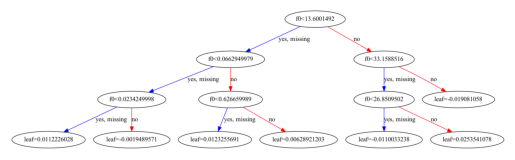

0:[f0<13.6001492] yes=1,no=2,missing=1
	1:[f0<0.0662949979] yes=3,no=4,missing=3
		3:[f0<0.0234249998] yes=7,no=8,missing=7
			7:leaf=0.0109706502
			8:leaf=-0.0020618001
		4:[f0<0.626659989] yes=9,no=10,missing=9
			9:leaf=0.0120798433
			10:leaf=0.00610300666
	2:[f0<33.1588516] yes=5,no=6,missing=5
		5:[f0<26.8509502] yes=11,no=12,missing=11
			11:leaf=-0.0109729823
			12:leaf=0.0252249241
		6:leaf=-0.0189755205



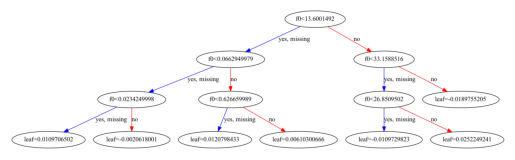

0:[f0<13.6001492] yes=1,no=2,missing=1
	1:[f0<0.0662949979] yes=3,no=4,missing=3
		3:[f0<0.0234249998] yes=7,no=8,missing=7
			7:leaf=0.0104174921
			8:leaf=-0.00239856401
		4:[f0<0.626659989] yes=9,no=10,missing=9
			9:leaf=0.0116284285
			10:leaf=0.00579899782
	2:[f0<33.1588516] yes=5,no=6,missing=5
		5:[f0<26.8509502] yes=11,no=12,missing=11
			11:leaf=-0.0109497784
			12:leaf=0.0250163507
		6:leaf=-0.0188749935



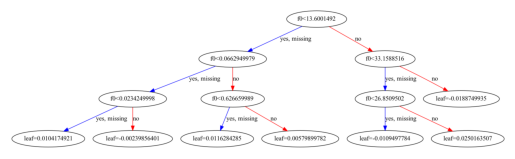

0:[f0<13.6001492] yes=1,no=2,missing=1
	1:[f0<0.0662949979] yes=3,no=4,missing=3
		3:[f0<0.0234249998] yes=7,no=8,missing=7
			7:leaf=0.0100423926
			8:leaf=-0.00261583878
		4:[f0<0.626659989] yes=9,no=10,missing=9
			9:leaf=0.0112767955
			10:leaf=0.00551911118
	2:[f0<33.1588516] yes=5,no=6,missing=5
		5:[f0<26.8509502] yes=11,no=12,missing=11
			11:leaf=-0.0109032448
			12:leaf=0.0248378273
		6:leaf=-0.0187853314



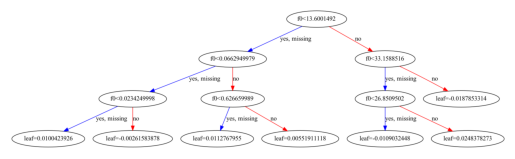

0:[f0<13.6001492] yes=1,no=2,missing=1
	1:[f0<0.0662949979] yes=3,no=4,missing=3
		3:[f0<0.0234249998] yes=7,no=8,missing=7
			7:leaf=0.00986106042
			8:leaf=-0.00265035359
		4:[f0<0.626659989] yes=9,no=10,missing=9
			9:leaf=0.0111065311
			10:leaf=0.00541292131
	2:[f0<33.1588516] yes=5,no=6,missing=5
		5:[f0<26.8509502] yes=11,no=12,missing=11
			11:leaf=-0.0108232405
			12:leaf=0.0247096531
		6:leaf=-0.0186735801



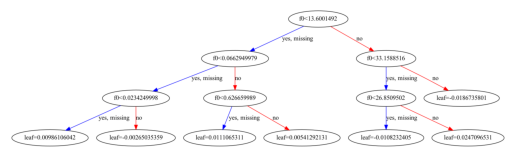

0:[f0<13.6001492] yes=1,no=2,missing=1
	1:[f0<0.0662949979] yes=3,no=4,missing=3
		3:[f0<0.0195799991] yes=7,no=8,missing=7
			7:leaf=0.0110110678
			8:leaf=-0.00254195137
		4:[f0<0.626659989] yes=9,no=10,missing=9
			9:leaf=0.0107644638
			10:leaf=0.00517106475
	2:[f0<33.1588516] yes=5,no=6,missing=5
		5:[f0<26.8509502] yes=11,no=12,missing=11
			11:leaf=-0.010756149
			12:leaf=0.0245422926
		6:leaf=-0.0185996164



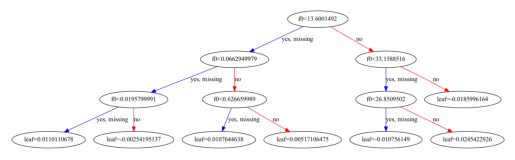

0:[f0<13.6001492] yes=1,no=2,missing=1
	1:[f0<0.0662949979] yes=3,no=4,missing=3
		3:[f0<0.0195799991] yes=7,no=8,missing=7
			7:leaf=0.0106355818
			8:leaf=-0.00274741137
		4:[f0<0.626659989] yes=9,no=10,missing=9
			9:leaf=0.0104456265
			10:leaf=0.00493507832
	2:[f0<33.1588516] yes=5,no=6,missing=5
		5:[f0<26.8509502] yes=11,no=12,missing=11
			11:leaf=-0.0106992722
			12:leaf=0.0243901778
		6:leaf=-0.018491406



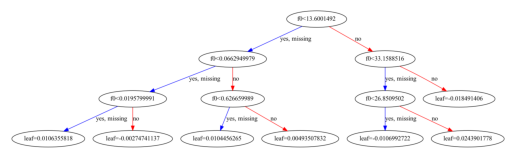

0:[f0<13.6001492] yes=1,no=2,missing=1
	1:[f0<0.0662949979] yes=3,no=4,missing=3
		3:[f0<0.0234249998] yes=7,no=8,missing=7
			7:leaf=0.00882304553
			8:leaf=-0.00318676024
		4:[f0<0.626659989] yes=9,no=10,missing=9
			9:leaf=0.0101947282
			10:leaf=0.00473405002
	2:[f0<33.1588516] yes=5,no=6,missing=5
		5:[f0<26.8509502] yes=11,no=12,missing=11
			11:leaf=-0.0106591461
			12:leaf=0.0242455006
		6:leaf=-0.0184086412



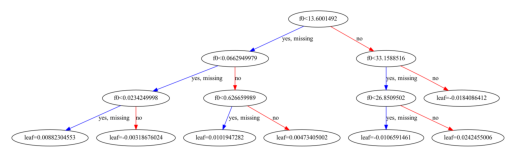

0:[f0<9.87001991] yes=1,no=2,missing=1
	1:[f0<0.0662949979] yes=3,no=4,missing=3
		3:[f0<0.0195799991] yes=7,no=8,missing=7
			7:leaf=0.0100043137
			8:leaf=-0.00303656631
		4:[f0<0.626659989] yes=9,no=10,missing=9
			9:leaf=0.00989861973
			10:leaf=0.00541679002
	2:[f0<15.5741501] yes=5,no=6,missing=5
		5:[f0<10.9608002] yes=11,no=12,missing=11
			11:leaf=-0.00920185074
			12:leaf=0.00264774496
		6:[f0<33.1588516] yes=13,no=14,missing=13
			13:leaf=-0.00878792536
			14:leaf=-0.0183344483



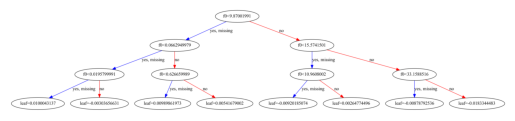

0:[f0<9.87001991] yes=1,no=2,missing=1
	1:[f0<0.0662949979] yes=3,no=4,missing=3
		3:[f0<0.0234249998] yes=7,no=8,missing=7
			7:leaf=0.00832152646
			8:leaf=-0.00340457819
		4:[f0<0.626659989] yes=9,no=10,missing=9
			9:leaf=0.00971384812
			10:leaf=0.00525882188
	2:[f0<15.5741501] yes=5,no=6,missing=5
		5:[f0<10.4524002] yes=11,no=12,missing=11
			11:leaf=-0.0111984406
			12:leaf=0.00176685106
		6:[f0<33.1588516] yes=13,no=14,missing=13
			13:leaf=-0.00873372983
			14:leaf=-0.0182232838



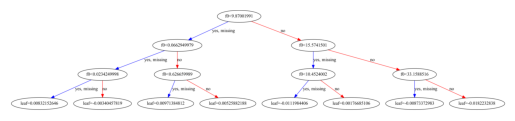

In [6]:
dump = model_with_constraints.get_dump()

counter = 0

for i in range(0, len(dump)):
    if counter == 10:
        break
    
    if any(x in dump[i] for x in ["f0", "f1<"]):
        counter += 1
        print(dump[i])
        xgb.plot_tree(model_with_constraints, num_trees = i)
        plt.show()

Perfect, we see only f0 with itself and f1 with itself, however we can check that easily:

In [7]:
variables_used_in_tree = [re.findall(r"f\d+", dump[x]) for x in range(0, len(dump))]

f0_trees = []
f1_trees = []

for i in range(0, len(dump)):
    if "f0" in variables_used_in_tree[i]:
        unique_features = list(set(variables_used_in_tree[i]))
        f0_trees.append(len(unique_features))
    elif "f1" in variables_used_in_tree[i]:
        unique_features = list(set(variables_used_in_tree[i]))
        f1_trees.append(len(unique_features))

if len(f0_trees) > 0:
    print(max(f0_trees))
if len(f1_trees) > 0:
    print(max(f1_trees))

1


Even more perfect! Now let's check f2 which is allowed to interact with f3 and f4, but not f3 and f4 together.

0:[f4<0.669499993] yes=1,no=2,missing=1
	1:[f4<0.627499998] yes=3,no=4,missing=3
		3:[f3<0.5] yes=7,no=8,missing=7
			7:leaf=0.0216697697
			8:leaf=0.0405947678
		4:[f3<0.5] yes=9,no=10,missing=9
			9:leaf=0.0421586931
			10:leaf=0.0886862949
	2:[f4<0.696500003] yes=5,no=6,missing=5
		5:[f4<0.675000012] yes=11,no=12,missing=11
			11:leaf=0.0102147432
			12:leaf=-0.0140669532
		6:[f2<18.8400002] yes=13,no=14,missing=13
			13:leaf=0.010957988
			14:leaf=0.00395214744



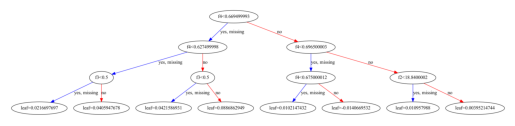

0:[f4<0.669499993] yes=1,no=2,missing=1
	1:[f4<0.627499998] yes=3,no=4,missing=3
		3:[f3<0.5] yes=7,no=8,missing=7
			7:leaf=0.0210460853
			8:leaf=0.0395954438
		4:[f3<0.5] yes=9,no=10,missing=9
			9:leaf=0.0411104225
			10:leaf=0.0872052461
	2:[f4<0.696500003] yes=5,no=6,missing=5
		5:[f4<0.675000012] yes=11,no=12,missing=11
			11:leaf=0.00998094026
			12:leaf=-0.0141300624
		6:[f2<18.8400002] yes=13,no=14,missing=13
			13:leaf=0.0106399786
			14:leaf=0.00362288416



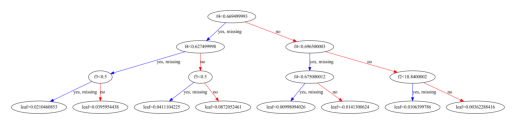

0:[f4<0.669499993] yes=1,no=2,missing=1
	1:[f4<0.627499998] yes=3,no=4,missing=3
		3:[f3<0.5] yes=7,no=8,missing=7
			7:leaf=0.0202502124
			8:leaf=0.0383810513
		4:[f3<0.5] yes=9,no=10,missing=9
			9:leaf=0.0398178846
			10:leaf=0.0853059366
	2:[f4<0.696500003] yes=5,no=6,missing=5
		5:[f4<0.675000012] yes=11,no=12,missing=11
			11:leaf=0.00953755341
			12:leaf=-0.014274165
		6:[f2<18.8400002] yes=13,no=14,missing=13
			13:leaf=0.0101949396
			14:leaf=0.00315453741



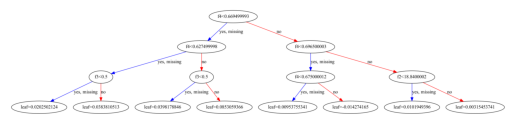

0:[f4<0.669499993] yes=1,no=2,missing=1
	1:[f4<0.627499998] yes=3,no=4,missing=3
		3:[f2<4.22000027] yes=7,no=8,missing=7
			7:leaf=0.0287358332
			8:leaf=0.018311711
		4:[f3<0.5] yes=9,no=10,missing=9
			9:leaf=0.0388026312
			10:leaf=0.0838759765
	2:[f4<0.696500003] yes=5,no=6,missing=5
		5:[f4<0.675000012] yes=11,no=12,missing=11
			11:leaf=0.00925515406
			12:leaf=-0.0142836273
		6:[f2<18.8400002] yes=13,no=14,missing=13
			13:leaf=0.00990196597
			14:leaf=0.00279106642



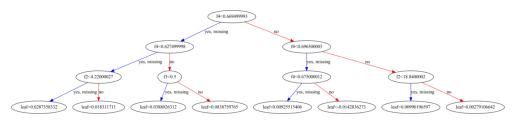

0:[f4<0.669499993] yes=1,no=2,missing=1
	1:[f4<0.627499998] yes=3,no=4,missing=3
		3:[f3<0.5] yes=7,no=8,missing=7
			7:leaf=0.0189134665
			8:leaf=0.0364989713
		4:[f3<0.5] yes=9,no=10,missing=9
			9:leaf=0.0375726148
			10:leaf=0.0820590928
	2:[f4<0.696500003] yes=5,no=6,missing=5
		5:[f4<0.675000012] yes=11,no=12,missing=11
			11:leaf=0.00882283226
			12:leaf=-0.0143879745
		6:[f2<18.8400002] yes=13,no=14,missing=13
			13:leaf=0.00950025022
			14:leaf=0.00236088363



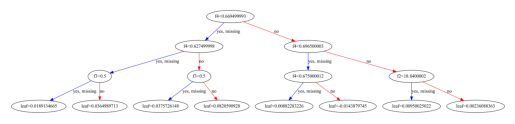

In [8]:
counter = 0
dump = model_with_constraints.get_dump()

for i in range(0, len(dump)):
    if counter == 5:
        break
    
    if "f2" and "f3" in dump[i]:
        counter += 1
        print(dump[i])
        xgb.plot_tree(model_with_constraints, num_trees = i)
        plt.show()

Now let's check if `f0-f4` only appear together and `f5-f12` only appear together.

In [9]:
features = ["f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12"]
controls = ["f0", "f1", "f2", "f3", "f4"]

for i in range(0, len(dump)):
    if all(item in controls for item in variables_used_in_tree[i]):
        pass
    elif all(item in features for item in variables_used_in_tree[i]):
        pass
    else:
        print(f"error here {i}")

Predict the model as-is and also with dummy levels for the control variables. 

In [10]:
df = pd.DataFrame(X_train).add_prefix("f")
df_control = df.copy()
df["response"] = y_train
df["xgb_predicted"] = model_with_constraints.predict(dtrain)

for var in ["f0", "f1", "f2", "f3", "f4"]:
    df_control[var] = 1
    
df["xgb_predicted_controlled"] = model_with_constraints.predict(xgb.DMatrix(df_control))

Now we can fit this score in a linear model to see if the control variables still have an impact and can reinject the signal that has been removed.

In [11]:
glm = GammaRegressor()
glm_controlled_removed = GammaRegressor()
glm_controlled_added = GammaRegressor()

# bin the predictions into a score:
df["xgb_predicted_"] = pd.qcut(df["xgb_predicted"], 50, labels = range(0, 50))
df["xgb_predicted_controlled_"] = pd.qcut(df["xgb_predicted_controlled"], 50, labels = range(0, 50))


glm.fit(np.transpose(df["xgb_predicted_"].to_numpy()).reshape(-1, 1), y_train)
glm_controlled_removed.fit(np.transpose(df["xgb_predicted_controlled_"].to_numpy()).reshape(-1, 1), y_train)
glm_controlled_added.fit(df[["xgb_predicted_controlled_", "f0", "f1", "f2", "f3", "f4"]].to_numpy(), y_train)

print(glm.coef_)
print(glm_controlled_removed.coef_)
print(glm_controlled_added.coef_)

[0.02619489]
[0.02592302]
[ 0.02649949 -0.00462085 -0.0004715   0.00459034  0.00436007 -0.00042024]


Plot each of the predictions to see if the errors reduce/enlarge depending on the effects being added/removed.

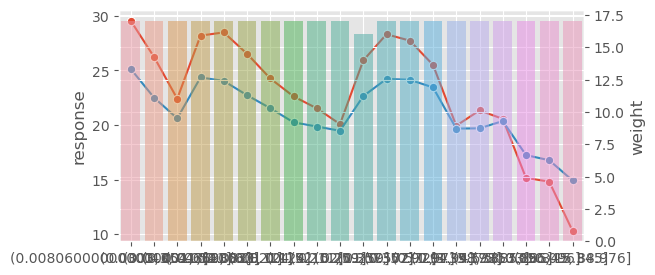

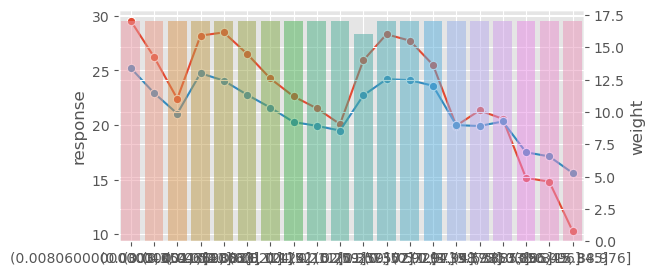

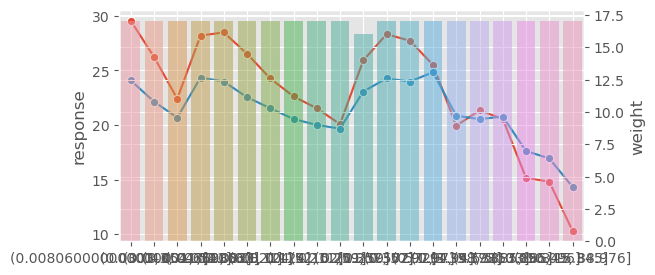

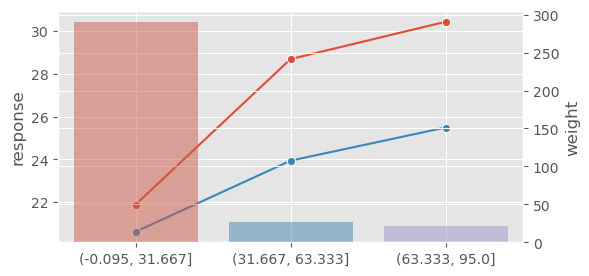

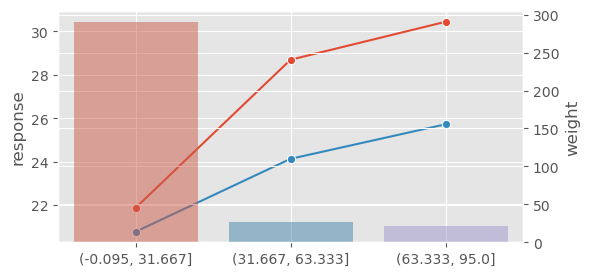

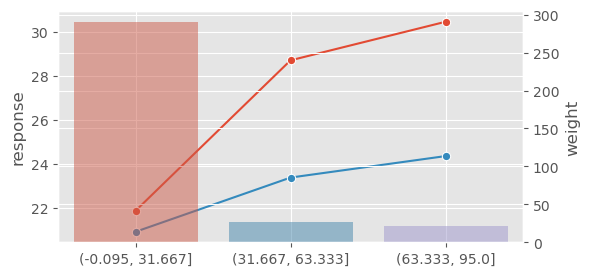

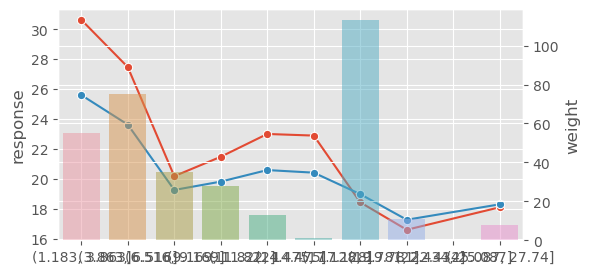

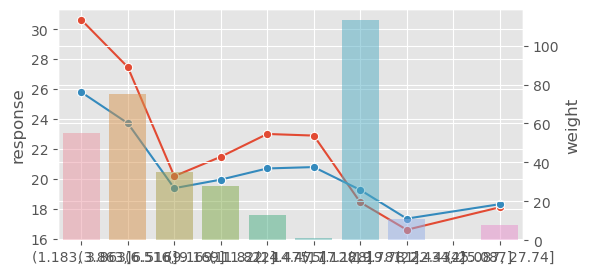

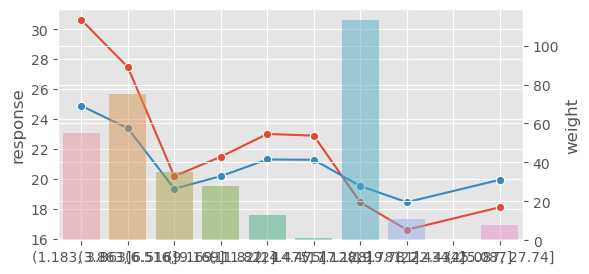

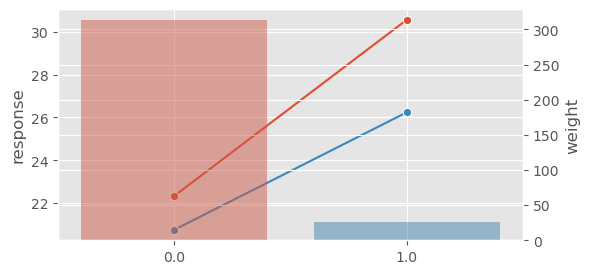

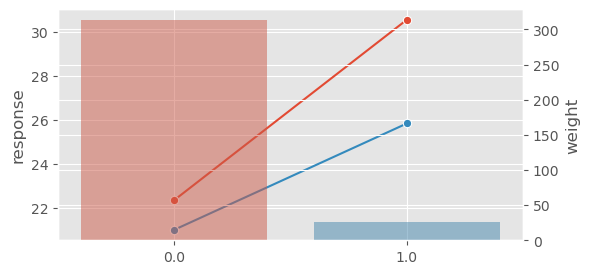

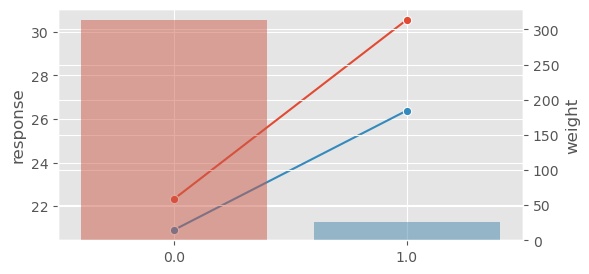

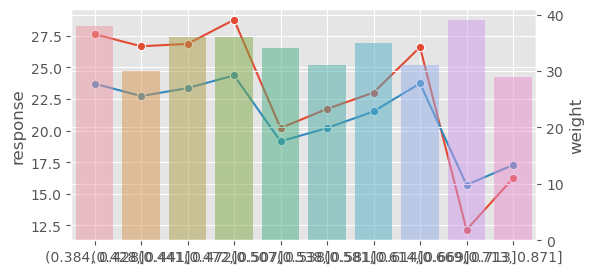

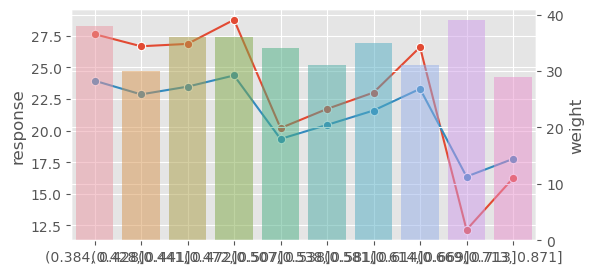

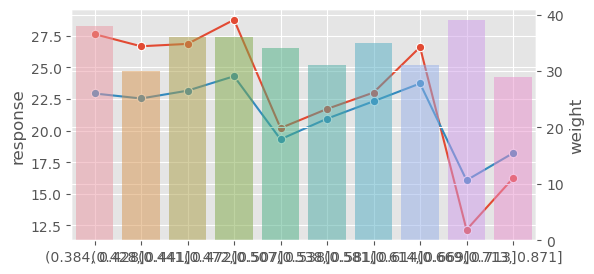

In [12]:
df["predicted_1"] = glm.predict(np.transpose(df["xgb_predicted"].to_numpy()).reshape(-1, 1))
df["predicted_2"] = glm_controlled_removed.predict(np.transpose(df["xgb_predicted_controlled"].to_numpy()).reshape(-1, 1))
df["predicted_3"] = glm_controlled_added.predict(df[["xgb_predicted_controlled", "f0", "f1", "f2", "f3", "f4"]].to_numpy())

df["f0_"] = pd.qcut(df["f0"], 20)
df["f1_"] = pd.cut(df["f1"], 3)
df["f2_"] = pd.cut(df["f2"], 10)
df["f4_"] = pd.qcut(df["f4"], 10)

for var in ["f0_", "f1_", "f2_", "f3", "f4_"]:
    plot_data = df.groupby(var).agg(weight = ("response", "size"),
                                response = ("response", "mean"),
                                 predicted1 = ("predicted_1", "mean"),
                                 predicted2 = ("predicted_2", "mean"),
                                   predicted3 = ("predicted_3", "mean")).reset_index()

    for i in ["predicted1", "predicted2", "predicted3"]:
        fig, ax1 = plt.subplots(figsize=(6, 3))
        sns.lineplot(data = plot_data["response"], marker = "o", sort = False, ax=ax1)
        sns.lineplot(data = plot_data[i], marker = "o", sort = False, ax=ax1)
        ax2 = ax1.twinx()

        sns.barplot(data = plot_data, x = var, y = "weight", alpha = 0.5, ax = ax2)

Ok, so the above method for building a GLM is horrible - let's be more technical about this. 

In [13]:
df_control_train = pd.DataFrame(X_train).add_prefix("f")
df_control_test = pd.DataFrame(X_test).add_prefix("f")

df_control_train_cp = df_control_train.copy()
df_control_test_cp = df_control_test.copy()

for var in ["f0", "f1", "f2", "f3", "f4"]:
    df_control_train_cp[var] = 1
    df_control_test_cp[var] = 1
    

f5_train = model_with_constraints.predict(xgb.DMatrix(df_control_train_cp))
f5_test = model_with_constraints.predict(xgb.DMatrix(df_control_test_cp))

f5_train_binned, bins = pd.qcut(pd.Series(f5_train), 50, labels=range(0, 50), retbins=True)
f5_test_binned = pd.cut(pd.Series(f5_test), bins=bins, labels=range(0, 50), include_lowest=True)

df_control_train["f5"] = f5_train_binned
glm_X_train = df_control_train[["f0", "f1", "f2", "f3", "f4", "f5"]].to_numpy()

# glm_X_train = np.c_[df_control_train[["f0", "f1", "f2", "f3", "f4"]].to_numpy(), f5_train_binned]
glm_X_test = np.c_[df_control_test[["f0", "f1", "f2", "f3", "f4"]].to_numpy(), f5_test_binned]

In [14]:
dtrain = xgb.DMatrix(glm_X_train, y_train)
dtest = xgb.DMatrix(glm_X_test, y_test)

params = {"max_depth": 2, "eta": 0.01, "objective": "reg:squarederror"}

params_constrained = params.copy()

params_constrained["interaction_constraints"] = "[[0], [1], [2, 3], [2, 4], [3, 4], [5]]"
# Features 0, 1 and 5 are not allowed to interact with any other feature
# Features 2 and 3 are allowed to interact with each other but with no other feature
# Features 2 and 4 are allowed to interact with each other but with no other feature
# Features 3 and 4 are allowed to interact with each other but with no other feature


watchlist = [(dtrain, "train"), (dtest, "eval")]

glm_xgb_model = xgb.train(
    params_constrained, 
    dtrain,
    num_boost_round = 10000,
    evals = watchlist,
    early_stopping_rounds = 5,
    verbose_eval=False
)


num_round = glm_xgb_model.best_iteration
glm_xgb_model = xgb.train(
    params_constrained, 
    dtrain, 
    num_boost_round = num_round, 
    evals = watchlist,
    verbose_eval = 50
)

# run prediction
preds = glm_xgb_model.predict(dtest)
labels = dtest.get_label()

[0]	train-rmse:24.11819	eval-rmse:22.64547
[50]	train-rmse:14.90516	eval-rmse:14.17636
[100]	train-rmse:9.30165	eval-rmse:9.13368
[150]	train-rmse:5.91142	eval-rmse:6.25060
[200]	train-rmse:3.89989	eval-rmse:4.71339
[250]	train-rmse:2.76089	eval-rmse:3.97425
[300]	train-rmse:2.16551	eval-rmse:3.64398
[350]	train-rmse:1.87312	eval-rmse:3.47655
[400]	train-rmse:1.73077	eval-rmse:3.39342
[450]	train-rmse:1.65898	eval-rmse:3.35140
[500]	train-rmse:1.61779	eval-rmse:3.33339
[550]	train-rmse:1.59170	eval-rmse:3.32360
[600]	train-rmse:1.57191	eval-rmse:3.31361
[650]	train-rmse:1.55526	eval-rmse:3.30616
[700]	train-rmse:1.54115	eval-rmse:3.30052
[750]	train-rmse:1.52913	eval-rmse:3.29633
[772]	train-rmse:1.52401	eval-rmse:3.29452


In [15]:
# Create a dataframe of the variable importances
dict_varImp = glm_xgb_model.get_score(importance_type = 'weight')
df_ = pd.DataFrame(dict_varImp, index = ['varImp']).transpose().reset_index()
df_.columns = ['feature', 'fscore']

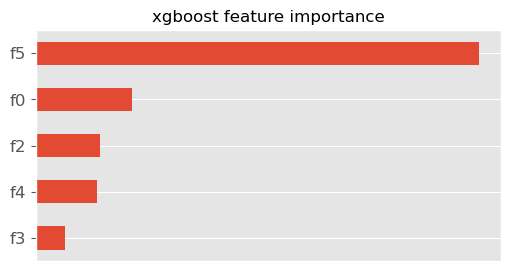

In [16]:
# Plot the relative importance of the top 10 features
df_['fscore'] = df_['fscore'] / df_['fscore'].max()
df_.sort_values('fscore', ascending = False, inplace = True)
df_ = df_[0:10]
df_.sort_values('fscore', ascending = True, inplace = True)
df_.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 3))
plt.title('xgboost feature importance', fontsize = 12)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks(fontsize=12)
plt.show()

In [17]:
from itertools import combinations

dump = glm_xgb_model.get_dump()
variables_used_in_tree = [re.findall(r"f\d+", dump[x]) for x in range(0, len(dump))]
variables_used_in_tree

interactions = []
for i in range(0, len(dump)):
    tree_var_list = list(set(variables_used_in_tree[i]))
    
    if len(tree_var_list) > 1:
        if len(tree_var_list) > 2:
            xgb.plot_tree(glm_xgb_model, num_trees = i)
            for c in combinations(tree_var_list, 2):
                interactions.append(list(c))
        else:
            interactions.append(tree_var_list)
    
pd.Series(interactions).value_counts()

[f4, f2]    70
[f3, f4]    50
[f2, f4]     2
dtype: int64

In [18]:
pd_data = df_control_train[["f0", "f1", "f2", "f3", "f4", "f5"]]
# pd_data["f5"] = f5_train_binned

def partial_dependency(model, data, variable):
    
    data_ = data.copy()

    levels = data_[variable].unique()
    scoring_data = data_.iloc[0:len(levels)].copy()
    
    for i in range(0, len(levels)):
        scoring_data[variable].iloc[i] = levels[i]
        
    scoring_data["prediction"] = model.predict(xgb.DMatrix(scoring_data.to_numpy()))
    data_["weight"] = 1
    plot_data = data_.groupby(variable).agg(weight = ("weight", "sum")).reset_index()
    
    plot_data = pd.merge(scoring_data, plot_data, on = [variable])
    
    fig, ax1 = plt.subplots(figsize=(6, 3))
    sns.lineplot(data = plot_data["prediction"], marker = "o", sort = False, ax=ax1)
    ax2 = ax1.twinx()

    sns.barplot(data = plot_data, x = var, y = "weight", alpha = 0.5, ax = ax2)

/var/folders/wd/qp852v8j47g6mk8gfmdtjktw0000gn/T/ipykernel_96434/657221802.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scoring_data[variable].iloc[i] = levels[i]
/var/folders/wd/qp852v8j47g6mk8gfmdtjktw0000gn/T/ipykernel_96434/657221802.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scoring_data[variable].iloc[i] = levels[i]
/var/folders/wd/qp852v8j47g6mk8gfmdtjktw0000gn/T/ipykernel_96434/657221802.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

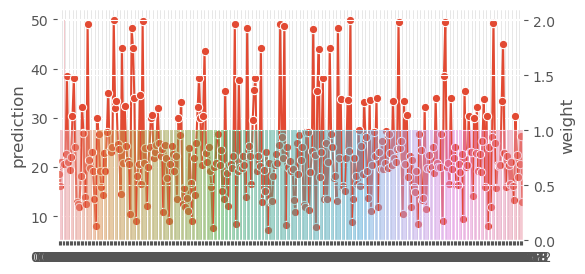

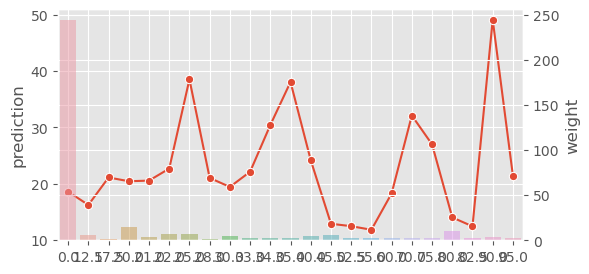

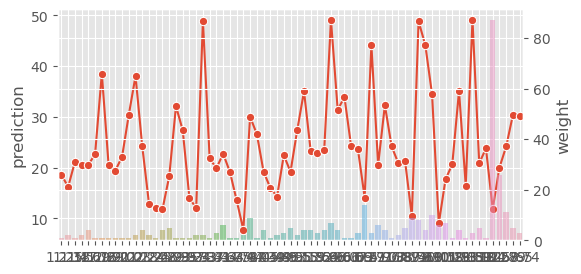

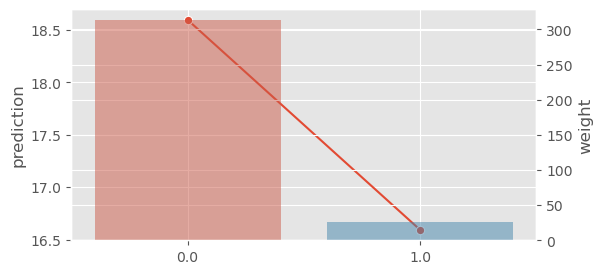

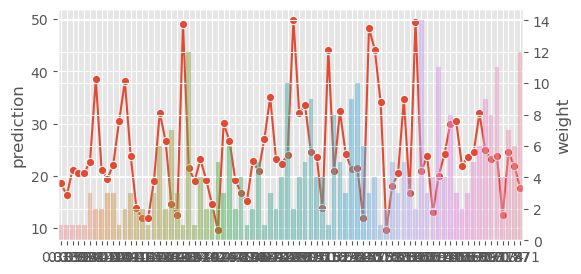

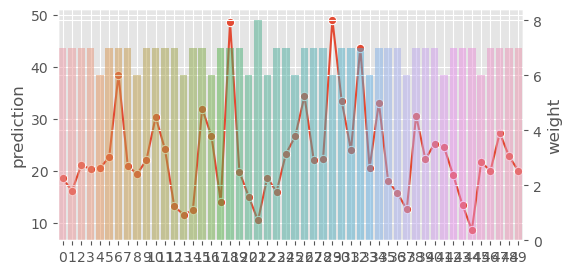

In [19]:
for var in ["f0", "f1", "f2", "f3", "f4", "f5"]:
    partial_dependency(glm_xgb_model, pd_data, var)